In [ ]:
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, concatenate, Conv2DTranspose, Conv2D, MaxPooling2D, Dropout
from keras import regularizers
from keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import os
import imageio
import cv2
# %matplotlib inline
# from google.colab.patches import cv2_imshow
# import cv2 as cv
#Replace cv2.imshow() to cv2_imshow()
# import numpy as np




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
working_directory = '/content/drive/MyDrive/DLproject'
original_img_dic = f'{working_directory}/original_images/'
# masked_img_dic = f'{working_directory}/RGB_color_image_masks/RGB_color_image_masks/'
masked_img_dic = f'{working_directory}/label_images_semantic/'

In [ ]:
# final_h,final_w = 96,128
final_h,final_w = 512,512
# final_h,final_w = 384,512
org_image_list = os.listdir(original_img_dic)
masked_image_list = os.listdir(masked_img_dic)
org_image_list = sorted([original_img_dic+i for i in org_image_list])
masked_image_list = sorted([masked_img_dic+i for i in masked_image_list])

train_org_image_list = org_image_list[:350]
train_masked_image_list = masked_image_list[:350]

test_org_image_list = org_image_list[350:400]
test_masked_image_list = masked_image_list[350:400]
# for i in range(len(train_org_image_list)):

  #  print(train_org_image_list[i],train_masked_image_list[i])
# x = np.random.randint((0,400))

# n = 222
# org_image = img.imread(train_org_image_list[n])
# print(org_image.shape)
# masked_image = img.imread(train_masked_image_list[n])
# print(masked_image.shape)

# fig ,arr  = plt.subplots(1,2,figsize=(15,10))
# arr[0].imshow(org_image)
# arr[0].set_title('Original Image')
# arr[1].imshow(masked_image)
# arr[1].set_title('Mask')
# plt.show()

# def resize(org_image,masked_image) :
#     org_image = tf.image.resize(org_image,(512,512),method='nearest')
#     masked_image = tf.image.resize(masked_image,(512,512),method='nearest')
#     return org_image , masked_image

# i,j = resize(org_image,masked_image)

# print(i.shape)
# # masked_image = img.imread(train_masked_image_list[n])
# print(j.shape)

# fig ,arr  = plt.subplots(1,2,figsize=(15,10))
# arr[0].imshow(i)
# arr[0].set_title('Original Image after resize')
# arr[1].imshow(j)
# arr[1].set_title('Masked image after resize')
# plt.show()

In [ ]:
def convolution_layer(inputs = None,filters = 32,dropout = 0,max_pooling = True):
    conv = Conv2D(filters,kernel_size = 3,activation='relu',padding='same',kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    conv = Conv2D(filters,kernel_size = 3,activation='relu',padding='same',kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    if dropout > 0:
        conv = Dropout(dropout)(conv)
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
    else:
        next_layer = conv

    skip_connection = conv
    return next_layer, skip_connection


def upsampling(expansive_input,contractive_input,filters =32,dropout = 0):
    up = Conv2DTranspose(filters,kernel_size = 3,strides=(2,2),padding='same')(expansive_input)
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(filters,kernel_size = 3,activation='relu',padding='same',kernel_initializer=tf.keras.initializers.HeNormal())(merge)
    if dropout > 0:
        conv = Dropout(dropout)(conv)
    conv = Conv2D(filters,kernel_size = 3,activation='relu',padding='same',kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    return conv



In [ ]:
def Unet(input_size = (final_h,final_w,3),filters = 32,classes = 23):
    inputs = Input(input_size)

    #encoding block
    c_1 = convolution_layer(inputs,filters,dropout=0.1)
    c_2 = convolution_layer(c_1[0],2*filters,dropout=0.2)
    c_3 = convolution_layer(c_2[0],4*filters,dropout=0.4)
    c_4 = convolution_layer(c_3[0],8*filters,dropout=0.4)
    c_5 = convolution_layer(c_4[0],16*filters,dropout=0.4)
    c_6 = convolution_layer(c_5[0],32*filters,dropout=0.4,max_pooling=None)

    u_6 = upsampling(c_6[0],c_5[1],16*filters,dropout = 0.45)
    u_7 = upsampling(u_6,c_4[1],8*filters,dropout = 0.45)
    u_8 = upsampling(u_7,c_3[1],4*filters,dropout = 0.4)
    u_9 = upsampling(u_8,c_2[1],2*filters,dropout = 0.2)
    u_10 = upsampling(u_9,c_1[1],filters,dropout = 0.1)

    conv10 = Conv2D(filters,kernel_size = 3,activation='relu',padding='same',kernel_initializer='he_normal')(u_10)

    conv11 = Conv2D(classes, kernel_size=1,padding='same', activation='softmax')(conv10)
    # conv11 = Conv2D(classes, kernel_size=1, padding='same')(conv10)

    model = Model(inputs=inputs, outputs=conv11)
    return model

Unet_model = Unet((final_h,final_w,3))
Unet_model.summary()
# Unet_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
Unet_model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['accuracy'])


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 512, 512, 32)         0         ['conv2d_1[0][0]']            
                                                                                              

In [ ]:
train_org_images = tf.constant(train_org_image_list)
train_masked_images = tf.constant(train_masked_image_list)
train_dataset = tf.data.Dataset.from_tensor_slices((train_org_images,train_masked_images))
# for image,mask in train_dataset.take(1) :
#     print(image)
#     print(mask)
test_org_images = tf.constant(test_org_image_list)
test_masked_images = tf.constant(test_masked_image_list)
test_dataset = tf.data.Dataset.from_tensor_slices((test_org_images,test_masked_images))
# for image,mask in test_dataset.take(1) :
#     print(image)
#     print(mask)
print(train_org_images[0],train_masked_images[0])


tf.Tensor(b'/content/drive/MyDrive/DLproject/original_images/000.jpg', shape=(), dtype=string) tf.Tensor(b'/content/drive/MyDrive/DLproject/label_images_semantic/000.png', shape=(), dtype=string)


In [ ]:
def process_path(image_path,mask_path):
    org_image = tf.io.read_file(image_path)
    org_image = tf.image.decode_png(org_image,channels=3)
    org_image = tf.image.convert_image_dtype(org_image,tf.float32)

    masked_image = tf.io.read_file(mask_path)
    masked_image = tf.image.decode_png(masked_image,channels=3)
    masked_image = tf.math.reduce_max(masked_image,axis=-1,keepdims=True)
    return org_image , masked_image

def resize(org_image,masked_image) :
    org_image = tf.image.resize(org_image,(final_h,final_w),method='nearest')
    masked_image = tf.image.resize(masked_image,(final_h,final_w),method='nearest')

    return org_image , masked_image

In [ ]:
train_image_data = train_dataset.map(process_path)
print(train_image_data)
final_train_image_data = train_image_data.map(resize)

test_image_data = test_dataset.map(process_path)
print(test_image_data)
final_test_image_data = test_image_data.map(resize)
print(final_train_image_data)
print(final_train_image_data)

<_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(512, 512, 1), dtype=tf.uint8, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(512, 512, 1), dtype=tf.uint8, name=None))>


In [ ]:
epoch = 150
batch_size=16
buffer = 350

# train
final_train_image_data.batch(batch_size)
final_train_dataset = final_train_image_data.cache().shuffle(buffer).batch(batch_size)
print(final_train_dataset.element_spec)

# validation
final_test_image_data.batch(batch_size)
final_test_dataset = final_test_image_data.cache().shuffle(buffer).batch(batch_size)
print(final_test_dataset.element_spec)

model = Unet_model.fit(final_train_dataset,epochs=epoch)

(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.uint8, name=None))
(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.uint8, name=None))
Epoch 1/150
22/22 [==============================] - 612s 3s/step - loss: 5.3546 - accuracy: 0.3235
Epoch 2/150
22/22 [==============================] - 44s 2s/step - loss: 2.3808 - accuracy: 0.4100
Epoch 3/150
22/22 [==============================] - 44s 2s/step - loss: 2.0982 - accuracy: 0.4816
Epoch 4/150
22/22 [==============================] - 43s 2s/step - loss: 1.9508 - accuracy: 0.5044
Epoch 5/150
22/22 [==============================] - 44s 2s/step - loss: 1.8471 - accuracy: 0.5223
Epoch 6/150
22/22 [==============================] - 44s 2s/step - loss: 1.6991 - accuracy: 0.5511
Epoch 7/150
22/22 [==============================] - 43s 2s/step - loss: 1.7087 - accuracy: 0.5327
Epoch 8/150
22/22 [=================

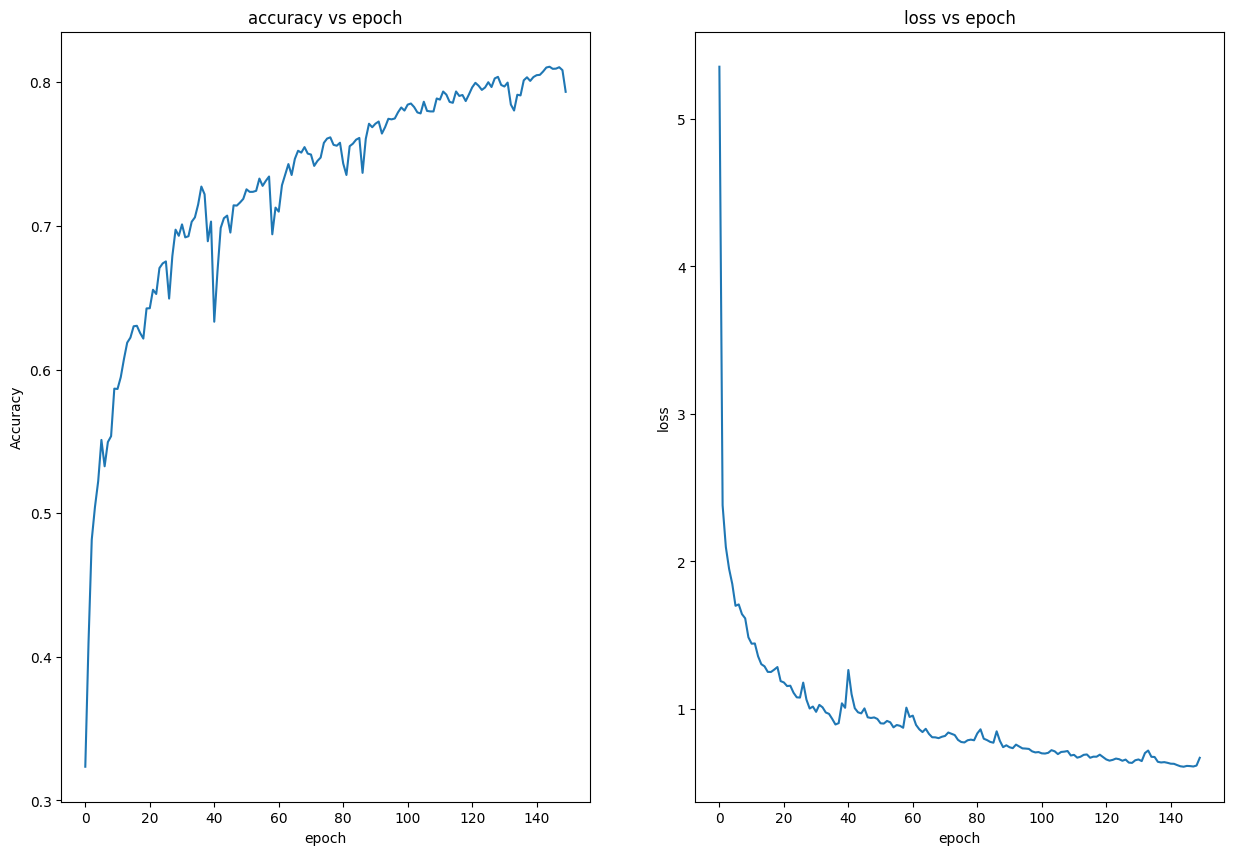

In [ ]:
fig ,ax  = plt.subplots(1,2,figsize=(15,10))
ax[0].plot(model.history['accuracy'])
ax[0].set_title('accuracy vs epoch')
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("Accuracy")
ax[1].plot(model.history['loss'])
ax[1].set_title('loss vs epoch')
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("loss")
plt.show()

In [ ]:
def load_model(model_name):
  model_path = f"{working_directory}/{model_name}"
  model = tf.keras.models.load_model(model_path)
  return model



In [ ]:
model_name = f"{final_h}_{final_w}_{Unet_model.count_params()}"
Unet_model.save(f"{working_directory}/{model_name}")

In [ ]:
mod = load_model(model_name)

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(model,dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            # plt.imshow(image[0])
            # print(image.shape)
            # plt.show()
            pred_mask = model.predict(image)
            # plt.imshow(create_mask(pred_mask))
            display([image[0], mask[0], create_mask(pred_mask)])
    # else:
    #     display([sample_image, sample_mask,
    #          create_mask(Unet_model.predict(sample_image[tf.newaxis, ...]))])

training_dataset results:

1/1 [==============================] - 0s 53ms/step


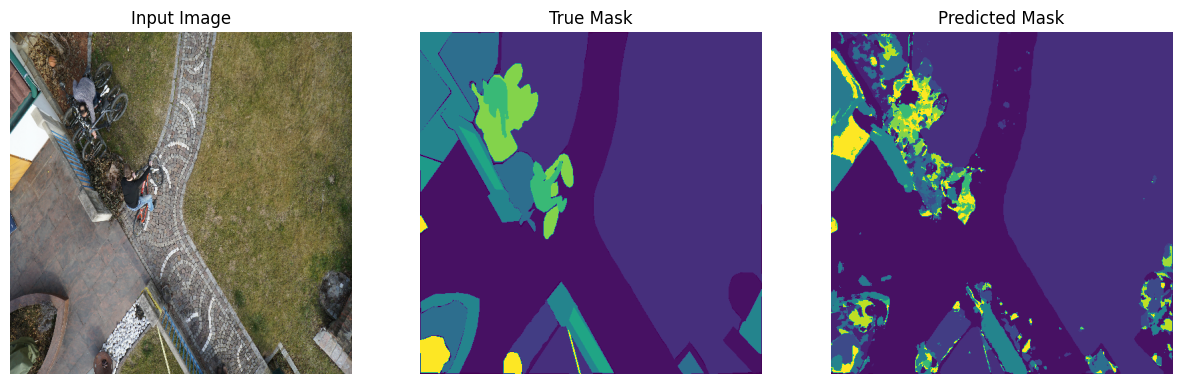

In [ ]:
print("training_dataset results:\n")
show_predictions(mod,final_train_dataset, 1)
# print("test_dataset results:\n")
# show_predictions(mod,final_test_dataset, 1)

test_dataset results:

1/1 [==============================] - 0s 131ms/step


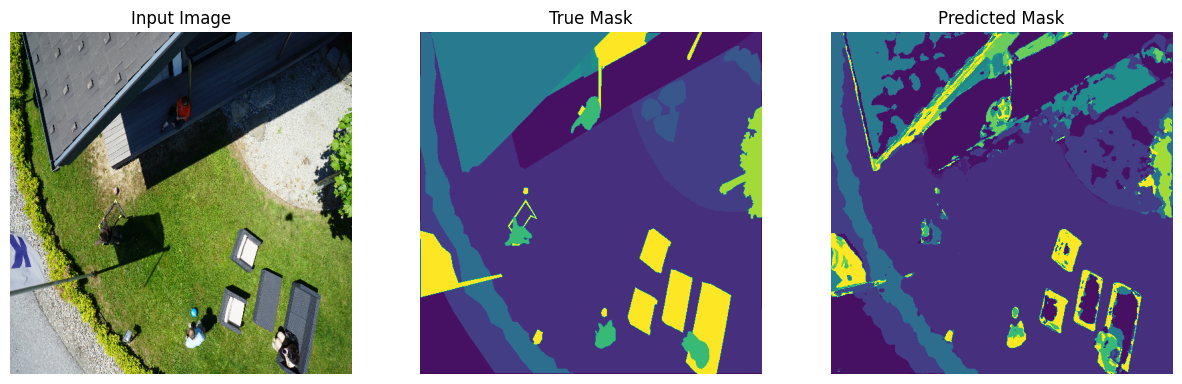

1/1 [==============================] - 0s 66ms/step


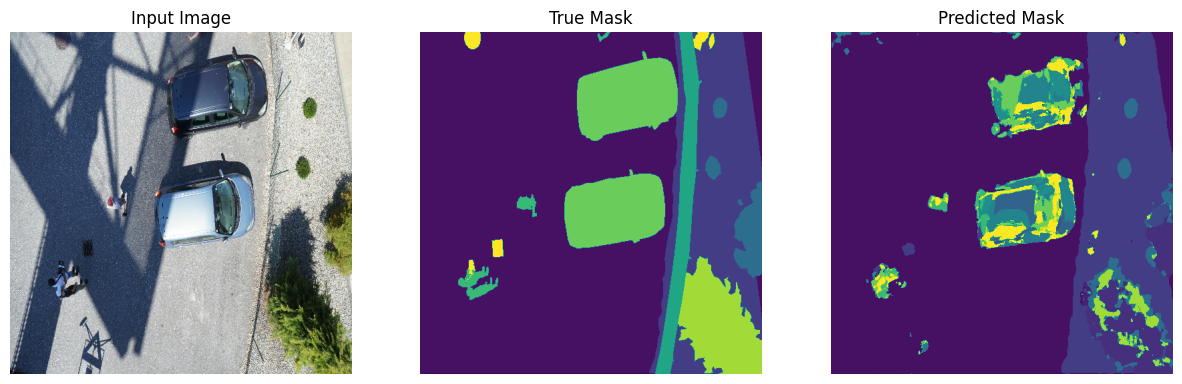

In [ ]:
print("test_dataset results:\n")
show_predictions(mod,final_test_dataset, 2)

In [ ]:
# model evaluation
print("Unet Model Evaluation: ")
mod.evaluate(final_test_dataset)

Unet Model Evaluation: 
4/4 [==============================] - 4s 1s/step - loss: 0.6981 - accuracy: 0.7882


[0.6981475949287415, 0.7881889939308167]

In [ ]:
h = 512
w = 512
model_name = "512_512_34596311"
mod = load_model(model_name)





In [ ]:
mod.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 512, 512, 32)         0         ['conv2d_1[0][0]']            
                                                                                              

In [ ]:
local_images = f'{working_directory}/Localtestset/'
image = img.imread(f'{local_images}{1}.jpg')
image = tf.image.resize(image,(h,w),method='nearest')
print(image.shape)

# def prediction(model,local_image):
#   pred_mask = model.predict(local_image)
#   pred_mask = tf.argmax(pred_mask, axis=-1)
#   pred_mask = pred_mask[..., tf.newaxis]
#   plt.imshow()

(512, 512, 3)


In [ ]:
def process_local_path(image_path):
    org_image = tf.io.read_file(image_path)
    org_image = tf.image.decode_png(org_image,channels=3)
    org_image = tf.image.convert_image_dtype(org_image,tf.float32)

    # masked_image = tf.io.read_file(mask_path)
    # masked_image = tf.image.decode_png(masked_image,channels=3)
    # masked_image = tf.math.reduce_max(masked_image,axis=-1,keepdims=True)
    return org_image

def resize_local_image(org_image) :
    org_image = tf.image.resize(org_image,(h,w),method='nearest')
    # masked_image = tf.image.resize(masked_image,(final_h,final_w),method='nearest')

    return org_image

In [ ]:
local_images_list = os.listdir(local_images)
test_local_image_list = sorted([local_images+i for i in local_images_list])
print(test_local_image_list)
test_local_images = tf.constant(test_local_image_list)
print(test_local_images)
test_dataset = tf.data.Dataset.from_tensor_slices(test_local_images)
for image in test_dataset.take(4) :
    print(image)
#     print(mask)




['/content/drive/MyDrive/DLproject/Localtestset/1.jpg', '/content/drive/MyDrive/DLproject/Localtestset/2.jpg', '/content/drive/MyDrive/DLproject/Localtestset/3.jpg', '/content/drive/MyDrive/DLproject/Localtestset/4.jpg', '/content/drive/MyDrive/DLproject/Localtestset/5.jpg']
tf.Tensor(
[b'/content/drive/MyDrive/DLproject/Localtestset/1.jpg'
 b'/content/drive/MyDrive/DLproject/Localtestset/2.jpg'
 b'/content/drive/MyDrive/DLproject/Localtestset/3.jpg'
 b'/content/drive/MyDrive/DLproject/Localtestset/4.jpg'
 b'/content/drive/MyDrive/DLproject/Localtestset/5.jpg'], shape=(5,), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/DLproject/Localtestset/1.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/DLproject/Localtestset/2.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/DLproject/Localtestset/3.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/DLproject/Localtestset/4.jpg', shape=(), dtype=string)


In [ ]:
test_local_image_data = test_dataset.map(process_local_path)
print(test_local_image_data)
final_test_local_image_data = test_local_image_data.map(resize_local_image)
print(final_test_local_image_data)

<_MapDataset element_spec=TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None)>
<_MapDataset element_spec=TensorSpec(shape=(512, 512, 3), dtype=tf.float32, name=None)>


In [ ]:
batch_size = 1
buffer = 3
final_test_local_image_data.batch(batch_size)
final_test_local_dataset = final_test_local_image_data.cache().shuffle(buffer).batch(batch_size)
print(final_test_local_dataset.element_spec)

TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None)


In [ ]:
def display_local(display_list):
    plt.figure(figsize=(5,5))

    title = ['Input Image', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def create_local_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_local_predictions(model,dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image in dataset.take(num):
            # plt.imshow(image[0])
            # print(image.shape)
            # plt.show()
            pred_mask = model.predict(image)
            # plt.imshow(create_mask(pred_mask))
            display_local([image[0], create_local_mask(pred_mask)])
    # else:
    #     display([sample_image, sample_mask,
    #          create_mask(Unet_model.predict(sample_image[tf.newaxis, ...]))])

test_dataset results:

1/1 [==============================] - 0s 24ms/step


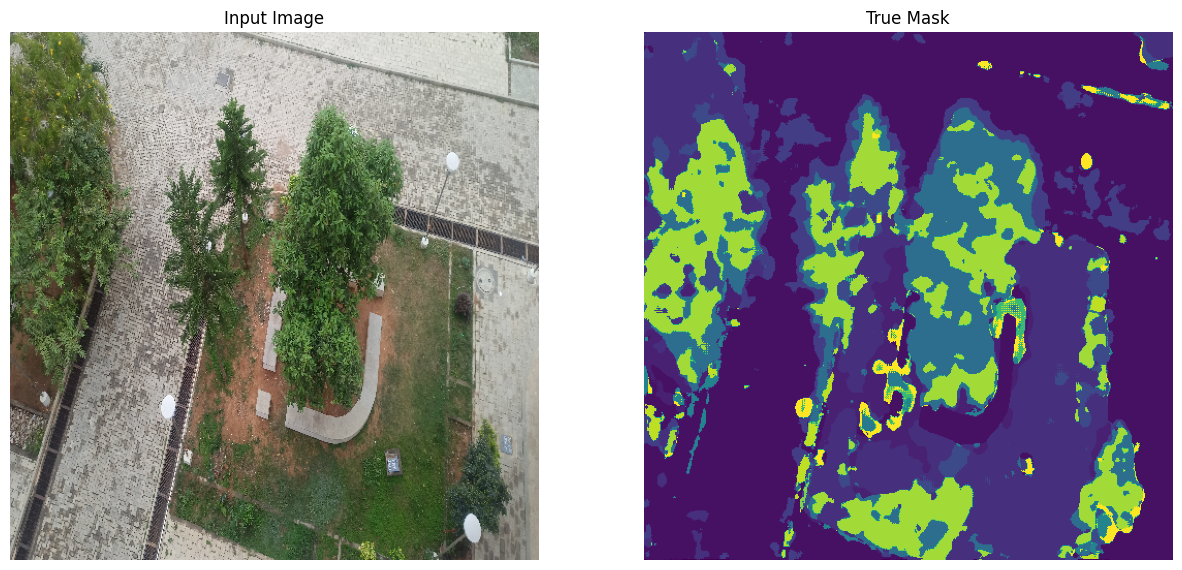

1/1 [==============================] - 0s 32ms/step


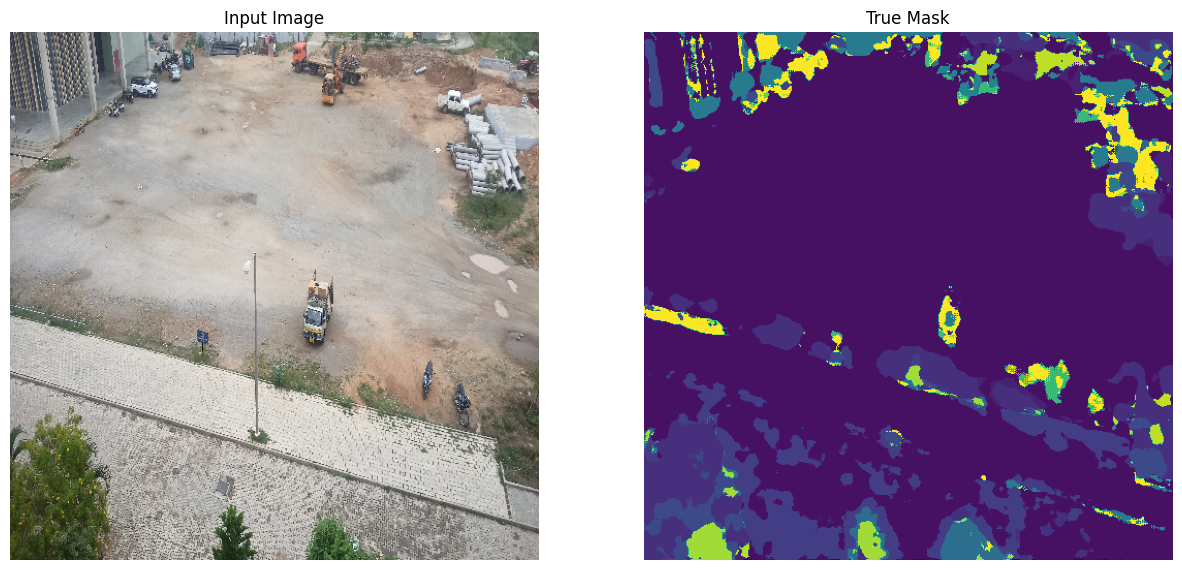

1/1 [==============================] - 0s 34ms/step


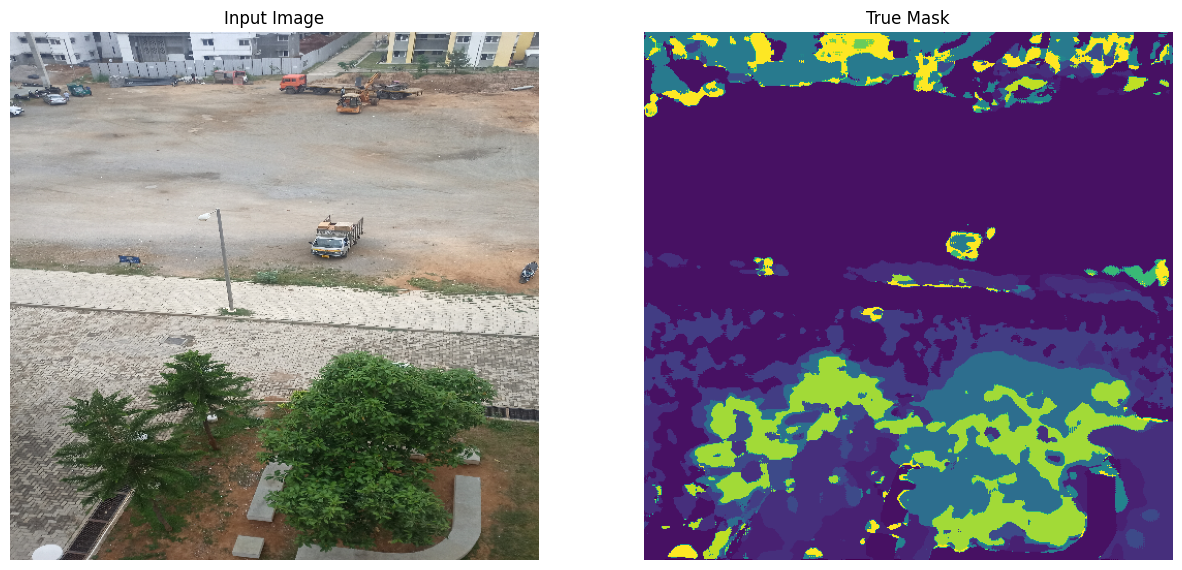

1/1 [==============================] - 0s 53ms/step


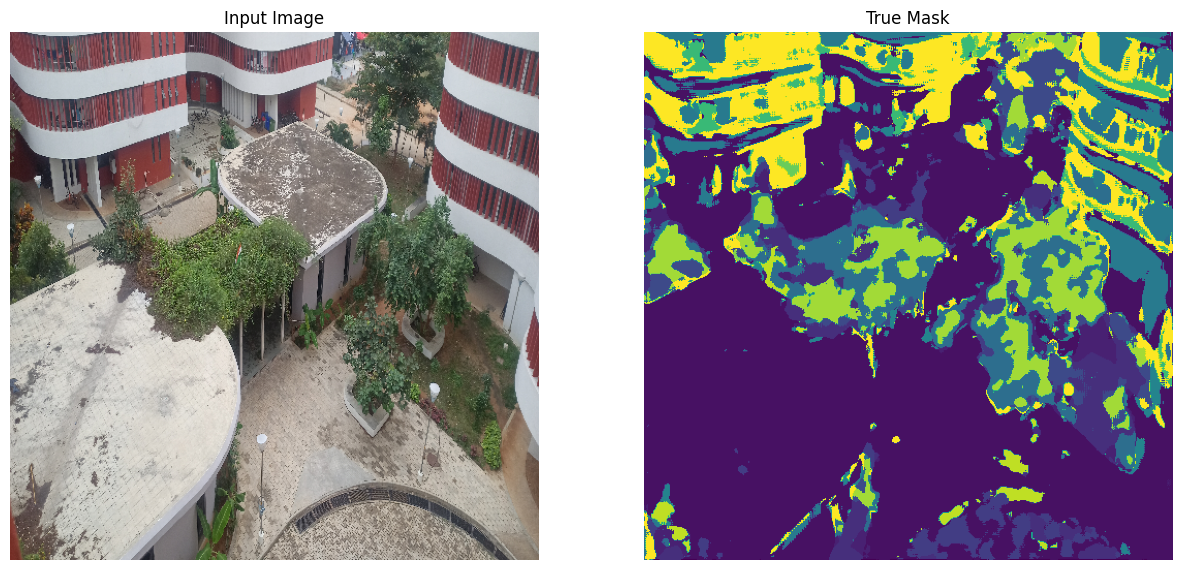

1/1 [==============================] - 0s 27ms/step


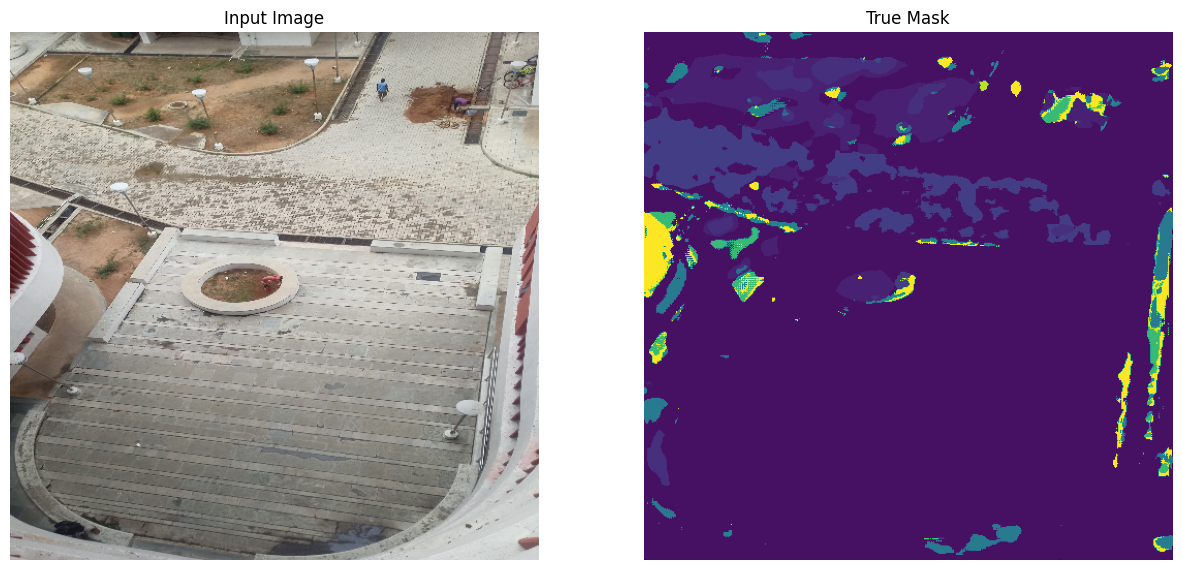

In [ ]:
print("test_dataset results:\n")
show_predictions(mod,final_test_local_dataset, 5)